### The Libraries
<p>Lets invoke some libraries we may need - Sklearn for Machine Learning part, Numpy for vector transformations, Pandas for the final summary, and some for Image Processing - cv2, skimage, matplotlib.pyplot,....)<p>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import cv2

In [3]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['axes.grid'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

<h3>The Machine Learning part</h3>
<p>The main idea is to use the image as (N_rows X N_columns X N_channels) vector. Considering this vector, it is possible to apply the K Means algorithm and identify k clusters, which will be our colors.</p>

<h4>Convert RGB to Hex Conversion & Read Image in RGB color space</h4>

In [4]:
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

<h4>Get colors from an image</h4>

In [5]:
image = get_image('inputimage.jpg')
number_of_colors = 10
modified_image = image.reshape(image.shape[0]*image.shape[1], 3)
clf = KMeans(n_clusters = number_of_colors)
labels = clf.fit_predict(modified_image)

In [6]:
counts = Counter(labels)

center_colors = clf.cluster_centers_

# We got ordered colors by iterating through the keys
ordered_colors = [center_colors[i] for i in counts.keys()]
hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
rgb_colors = [ordered_colors[i] for i in counts.keys()]

([<matplotlib.patches.Wedge at 0x7fd6be6574a8>,
 [Text(0.9442862693311689, 0.5642015965527069, '#26201a'),
  Text(0.17799929226624803, 1.085502764599296, '#ad9c8b'),
  Text(-0.5776434910873337, 0.9361239219272401, '#5e4e3e'),
  Text(-1.02750635571472, 0.3927221523747489, '#110d09'),
  Text(-1.0942356132659292, -0.11246520644419755, '#8a7968'),
  Text(-0.7343081288852438, -0.8190186639222896, '#776656'),
  Text(-0.13757946910678412, -1.0913624007085343, '#bdad9e'),
  Text(0.27943451422505955, -1.0639155757200873, '#e9e3db'),
  Text(0.8635489825398512, -0.6813832656841432, '#41372d'),
  Text(1.0843868707959854, -0.18467570074400988, '#9c8a79')])

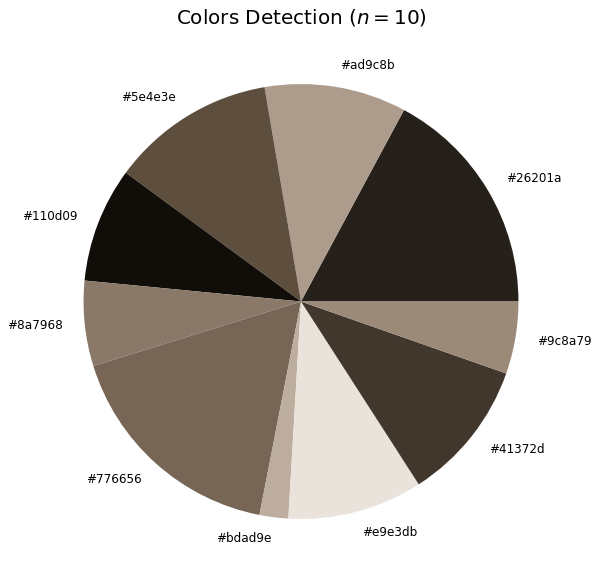

In [7]:
plt.title('Colors Detection ($n=10$)', fontsize=20)
plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)

<h3>The Image Processing part</h3>
<p>So now we can see the colors and identify them, but can we associate each element of the 'label' list to its correspondent color, well lets go ahead identify...

<p> The main idea is pretty simple - the image is RGB encoded which means that if we compute the difference between the image and the RGB expression of one of the colors, we get [0,0,0] exactly when the image is equal to the color.

<h4>Converting RGB in integer values.</h4>

In [23]:
for i in range(len(rgb_colors)):
    rgb_colors[i] = rgb_colors[i].astype(int)

<h4>Break the image into smaller squares</h4>
<p>In this case, we've chosen the dimension of each square to be N_rows/10 X N_columns/10, thus obtaining 100 squares.</p>

In [24]:
def square_maker():
    inp_img = image
    h = int(inp_img.shape[0])
    step_h = int(h/10) 
    w = int(inp_img.shape[1])
    step_w = int(w/10) 
    X = np.arange(0,h+step_h,step_h)
    Y =np.arange(0,w+step_w,step_w)
    squares = [inp_img[0:step_h,0:step_w]]
    for i in range(0,len(X)-1):
        for j in range(0,len(Y)-1):
            squares.append(inp_img[X[i]:X[i+1],Y[j]:Y[j+1]])
    return np.array(squares)[1::]

<h4>We will pick the color that, in average, is closer to 0 than the others.</h4>

In [25]:
def color_computing(array):
    DIFF = []
    squared_image = square_maker()
    for square in squared_image:
        DIFF_COLOR = []
        for color in range(len(rgb_colors)):
            diff = np.abs(square - rgb_colors[color])
            DIFF_COLOR.append(diff.mean())
        DIFF.append(DIFF_COLOR)
    return np.array(DIFF)

<h4>Plot the "best color" for each square</h4>

In [26]:
def best_color_plot(selected_slice):
    plt.subplot(1,2,1)
    plt.title('Retrieved Color')
    plt.imshow((np.zeros((16,16,3))+ rgb_colors[color_computing(image)[selected_slice].argmin()]).astype(int))
    plt.subplot(1,2,2)
    plt.title('Selected Square: '+ str(selected_slice))
    plt.imshow(square_maker()[selected_slice])

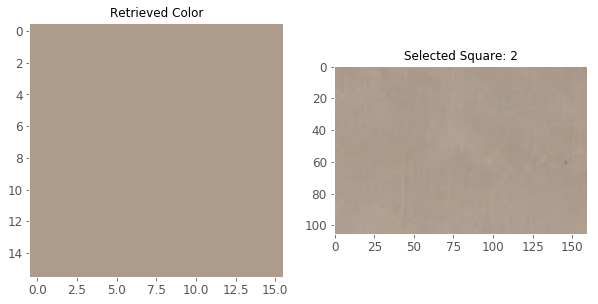

In [37]:
best_color_plot(2)

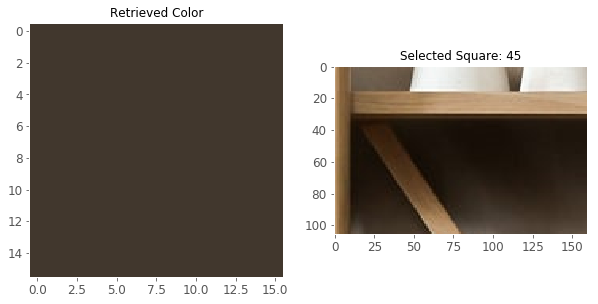

In [36]:
best_color_plot(45)

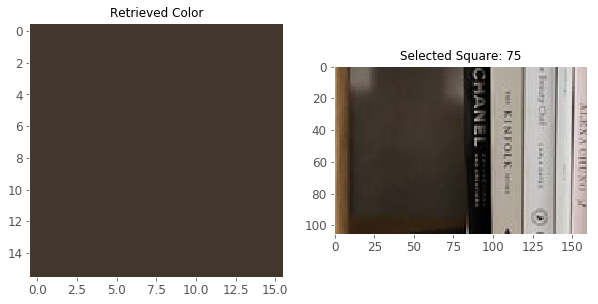

In [35]:
best_color_plot(75)

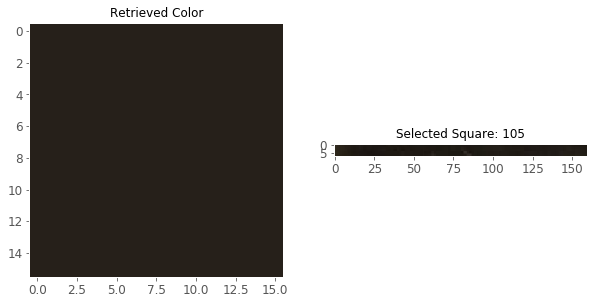

In [40]:
best_color_plot(105)

<h4>Summary of this example for all the squares of the image</h4>

In [42]:
def build_summary():
    results = color_computing(image)
    cols = ['Square Number'] + hex_colors
    sorted_results = pd.DataFrame(columns=cols)
    k=0
    
    for r in results:
        d = {'Square Number': int(k)}
        for c in range(len(hex_colors)):
            d[hex_colors[c]] = r[c]*100/r.sum()
        sorted_results = sorted_results.append(d, ignore_index=True)
        k = k+1
    sorted_results['Square Number'] = sorted_results['Square Number'].astype(int)
    return sorted_results

In [43]:
summary_df = build_summary()

In [44]:
summary_df.head()

,Square Number,#26201a,#ad9c8b,#5e4e3e,#110d09,#8a7968,#776656,#bdad9e,#e9e3db,#41372d,#9c8a79
0,0,19.322606,0.278997,12.174266,22.275181,5.492122,8.392898,2.640409,10.876540,15.748436,2.798545
1,1,19.306779,0.339202,12.114908,22.277335,5.392072,8.310513,2.789984,11.076271,15.710844,2.682092
2,2,19.314025,0.319594,12.161222,22.268443,5.474907,8.377493,2.662702,10.903975,15.737624,2.780015
3,3,19.238826,0.626566,11.926431,22.259164,5.090930,8.058279,3.228245,11.653397,15.582628,2.335535
4,4,19.051876,1.432892,11.452969,22.190554,4.349644,7.433258,4.295489,13.050750,15.252423,1.490145


<p>The number under each column are the percentage of the color for that specific square.</p>